# <center>Monte Carlo Simulation of $^{14}O(d,^{2}He)^{14}N$ Reaction with Recoil Reconstruction</center> #
### <center>Alex Carls</center> ###

***
## Motivation ##

**One of the tools to understanding the chemical abundances in the universe and the evolution of core collapse supernovae is in electron capture rates. Electron capture is the process in which a proton-rich nucleus absorbs an inner atomic electron to form a neutron:**

<img src = "electronCapture.png"  width="30%"/>

$$^{A}_{Z}X + e^{-} \rightarrow ^{A}_{Z-1}X + n + \nu_{e}$$

**These rates are determined by the strengths of the Gamow-Teller $(\Delta J = \pm 1; \Delta \pi = 0)$ transitions involved:**

$$\lambda_{EC} \propto \sum_{ij} f_{ij}(T,\rho,U_{f})B(GT)_{ij}$$

**These $B(GT)$ can be determined via $\beta$-decay experiments where either the parent nucleus either emits an electron or a positron. The resulting daughter nucleus will be in some excited state. We can look at the cross-sections for these excitations to determine to find the Gamow-Teller strengths.**

**Unfortunately, $\beta$-decay reactions are limited to low-lying excitation states (due to the Q-value of the reaction). For this reason, we consider performing charge-exchange reactions.**

***
## Charge-Exchange Reactions ##

**A charge-exchange reaction is one in which a proton in the target nucleus is exchanged for a neutron in the projectile or vice versa.**

<img src = "chargeExchange.png"  width="60%"/>
<center>Example of a (p,n) reaction in forward kinematics using a tritium projectile.</center>

**The benefit of these reactions is that states up to high excitation energies can be populated so a more complete picture of the Gamow-Teller strengths can be obtained. At intermediate energies (~100 MeV/u) and low momentum transfer (the projectile doesn't lose much energy and is not scattered to significant angles), there is a proportionality between the differential cross-section and the transition strength:**

$$\frac{d\sigma}{d\Omega}\vert_{q=0} = \hat{\sigma}B(GT)$$

***All the above is to say, if we want to understand the rates of reactions in stellar evolution, we simply need to determine the probabilities of populating the excited states of a nucleus using charge-exchange reactions.***



***
## Experiment ##

**Reactions in forward kinematics utilize a beam of low-mass particles incident on the nucleus, such as a proton beam or $^{3}$He beam. These beams are easily created with high rates and a breadth of energies. Many charge-exchange experiments in forward kinematics have been conducted to yield considerable statistics on a variety of target nuclei. The issue is that forward kinematics is limited to study of nuclei just around the valley of nuclear stability. This is due to the fact that the target nucleus has to be stable; otherwise, it will continuously decay during the course of the experiment and the data will be contaminated.**

<table><tr><td><img src='tableOfNuclides.png'></td><td><img src='areaOfStudy.png'></td></tr></table>

**The solution to this is performing experiments in inverse kinematics. With this method, the heavy particle is the projectile in the beam and the target can be composed of a lighter nucleus. The reason this is a feasible solution is that an unstable projected at relativistic speeds will experience a much longer life in the lab frame due to time dilation effects.**

**While hydrogen and $^{3}$He targets have been extensively used to study proton-rich nuclei, experiments studying neutron-rich nuclei are difficult due to the limited possibilities for targets. Neutron targets would have to be solid, which would greatly affect either the statistics or limit of the excitation energies. Tritium-gas targets are simply expensive. Using a $^{7}$Li target has yielded results but only for light nuclei and low excitation energies. The goal of this research is to experiment with a deuteron-gas target as a proof-of-principle test for a new method of studying neutron-rich nuclei.**

<img src = "attpc.png"  width="60%"/>
<center>Cross-section of the Active-Target Time Projection Chamber (AT-TPC).</center>

**The centerpiece of the experiment is the Active-Target Time Projection Chamber (AT-TPC). Time projection chambers are a type of detector that utilize the ionization of a gas inside its volume and electric fields to reconstruct the trajectory of a particle passing through. The AT-TPC will be filled with deuteron (one proton, one neutron) gas, which will also act as the target in the reaction (hence, the first part of the detector's name). With this method, experiments in the $(n,p)$ direction up to high excitation energies should be possible.**

**The additional complication that arises with this method however, is that the recoil particle from the exchange is $^{2}$He, which is unstable and immediately decays into two protons. In order to reconstruct the original $^{2}$He particle later calculations, the protons have to be tracked using time projection.**

***

In [1]:
#################################################
## Load in needed Python libraries and modules ##
#################################################

from __future__ import division, print_function

import numpy as np
from numpy import linalg as la

import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML, display

from keras.callbacks import Callback
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop
from keras.regularizers import l2
from keras.utils import np_utils

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import csv

Using TensorFlow backend.


In [2]:
############################################
## Some functions and constants to define ##
############################################

unitMass = 931.494                # MeV / amu
protonMass = 1.0078250322         # amu
deuteronMass = 2.01410177812      # amu
c = 299792458                     # m / s
energyConversion = 1.60218e-13    # Joules / MeV

def omega(x, y, z):
    # Just to simplify code later
    return (np.sqrt(x*x + y*y + z*z - 2*x*y - 2*y*z - 2*z*x))

def sq(x):
    return x*x

def transform(vectorTo, vectorFrom, vectorIn):
    # Using Rodrigues' Rotation formula (https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)
    # Transforms a vectorIn from an axial basis used by vectorFrom to an axial basis used by vectorTo
    
    # Find the vector normal to the plane spanned by vectorTo and vectorFrom
    n = [] 
    n.append(vectorTo[1] * vectorFrom[2] - vectorTo[2] * vectorFrom[1])
    n.append(vectorTo[2] * vectorFrom[0] - vectorTo[0] * vectorFrom[2])
    n.append(vectorTo[0] * vectorFrom[1] - vectorTo[1] * vectorFrom[0])
    
    # For n with very small norm, vectorFrom and vectorTo are essentially parallel, thus have the same basis
    if(la.norm(n) < 0.0001):
        return vectorIn
    
    n = n/la.norm(n)
    
    # Find the angle, alpha, between the axes of vectorFrom and vectorTo
    alpha = np.arccos(np.array(vectorTo).dot(np.array(vectorFrom)) / (la.norm(vectorTo) * la.norm(vectorFrom)))
    a = np.sin(alpha)
    b = 1.0 - np.cos(alpha)
    
    # Rotate vectorIn by angle alpha about axis perpendicular to the plane spanned by vectorFrom and vectorTo
    vectorOut = []
    vectorOut.append((1 - b * (n[1] * n[1] + n[2] * n[2])) * vectorIn[0] + (-a * n[2] + b * n[0] * n[1]) * vectorIn[1] + (a * n[1] + b * n[2] * n[0]) * vectorIn[2])
    vectorOut.append((1 - b * (n[2] * n[2] + n[0] * n[0])) * vectorIn[1] + (-a * n[0] + b * n[1] * n[2]) * vectorIn[2] + (a * n[2] + b * n[0] * n[1]) * vectorIn[0])
    vectorOut.append((1 - b * (n[0] * n[0] + n[1] * n[1])) * vectorIn[2] + (-a * n[1] + b * n[2] * n[0]) * vectorIn[0] + (a * n[0] + b * n[1] * n[2]) * vectorIn[1])
    
    return vectorOut

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    # Create a cylinder for plotting that represents the AT-TPC
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def plot3D(x, y, z):
    fig = plt.figure(0)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x,y,z)

    Xc,Yc,Zc = data_for_cylinder_along_z(0.,0.,0.3,1.)
    ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

    plt.show()

In [3]:
#################################################################
## Load the cross-sectional data file and particle information ##
## that corresponds to the specific reaction you want to study ##
#################################################################

# Read in data for the cross-sections
# crossSections[:,0] are the excitation energies
# crossSections[:,1] are the angles of the recoil
# crossSections[:,2] are the cross-sections for each energy and angle

crossSections = np.loadtxt( 'all2.dat' )

# Set up initial conditions of reaction
A = []   # mass number
Z = []   # atomic number
Q = []   # q-value for nucleus
M = []   # atomic mass number (amu)
ExE = [] # excitation energy
PxL = [] # x-component of momentum in lab frame
PyL = [] # y-component of momentum in lab frame
PzL = [] # z-component of momentum in lab frame

######## Beam | 14-Oxygen ######## 
KBeam = 100.0 # kinetic energy of beam MeV/u
A.append(14)
Z.append(8)
Q.append(0)
M.append(14.008596359)
ExE.append(0)
PxL.append(0)
PyL.append(0)
PzL.append(np.sqrt(sq(KBeam * A[0] + M[0] * unitMass) - sq(M[0] * unitMass)))

####### Target | Deuterium gas #######
A.append(2)
Z.append(1)
Q.append(0)
M.append(deuteronMass)
ExE.append(0)
PxL.append(0)
PyL.append(0)
PzL.append(0)

###### Ejectile | 14-Nitrogen ######
A.append(14)
Z.append(7)
Q.append(0)
M.append(14.0030740043)
ExE.append(0)
PxL.append(0)
PyL.append(0)
PzL.append(0)

####### Recoil | 2-Helium #######
A.append(2)
Z.append(2)
Q.append(0)
M.append(2.0 * protonMass)
ExE.append(0)
PxL.append(0)
PyL.append(0)
PzL.append(0)

###### Recoil Decay | Proton 1 ######
A.append(1)
Z.append(1)
Q.append(0)
M.append(protonMass)
ExE.append(0)
PxL.append(0)
PyL.append(0)
PzL.append(0)

###### Recoil Decay | Proton 2 ######
A.append(1)
Z.append(1)
Q.append(0)
M.append(protonMass)
ExE.append(0)
PxL.append(0)
PyL.append(0)
PzL.append(0)


***
## Monte Carlo Simulation ##

**This simulation calculates using relativistic two-body kinematics the momenta of recoil particles, $^{2}He$, resulting from the reaction. Monte Carlo methods are applied to determine the location at which the particles react as well as the energy and angle at which the recoil particle emerges. Since the $^{2}He$ recoil immediately decays, the two resulting particles must be tracked in order to reconstruct the $^{2}He$ particle. Applying a Neural Network with input tracks and their corresponding reaction points, new sample tracks can be fit to find the point of origin for the reaction.**

<img src = "kinematics.png"  width="60%"/>

**A derivation of the equations for the relativistic kinematics can be found at <a href="https://skisickness.com/2010/04/25/">this site</a>. Here is the general outline of the simulation:**
1. Generate point of reaction (projectile and target collision) using Monte Carlo method
    - Choose random position on z-axis and a second random number in same set of values
    - If random position is larger than random number, accept event location
    - As the position gets larger, the probability of being the greater number increases
        - This makes sense because the farther the beam makes it in the AT-TPC the greater the likelihood that the reaction will have occurred
1. Generate excitation energy and emergence angle of recoil particle using Monte Carlo method
    - Choose a random line in the cross-sections data file and a random number from 0 to 0.01
        - Each line in the file has an excitation energy, angle, and cross-section for those values
    - If the cross-section of that random line is greater than the random number, accept the energy and angle
1. Calculate center-of-mass frame momenta
    - First find the center-of-mass momentum using mass and energy of projectile and target
        - Due to conservation of momentum, the ejectile and recoil particles have the same total momentum
    - Calculate momentum of recoil particle using center-of-mass momentum and energy and angle found in previous step
    - Calculate momentum of ejectile particle
        - This is just same magnitude and opposite direction as recoil since we are still in the center-of-mass frame
    - This step of the outline corresponds to the left side of the diagram above
1. Convert from center-of-mass frame to lab frame
    - This requires a Lorentz transformation
    - This step of the outline corresponds to the right side of the diagram above
1. Generate the protons from the decay of the recoil
    - Choose any random theta and phi angles
        - The decay is isotropic so the resulting protons will be in any random direction
    - Calculate momentum of one proton using momentum of recoil particle and random angles just found
    - Calculate momentum of second proton
        - Same magnitude and opposite direction as first proton
1. Convert from center-of-mass frame to lab frame
    - This requires a Lorentz transformation
1. Transform from the recoil particle's axis to beam axis
    - The protons were created with angles and momenta that corresponded to the axis of the recoil particle's momentum
    - Use Rodrigues' rotation formula to rotate from this axis to the beam axis
1. Finally, the momenta of the particles and their masses can be used to find the actual speed
    - Use this speed and a small time step to observe the amount and direction the proton moves
    - Draw this movement
    
***

In [4]:
##################################################################
##              Monte Carlo simulation of reaction              ##
## Return histogram of counts in ATTPC and location of reaction ##
##################################################################

def reaction(beamE,a,z,q,m,exE,pxL,pyL,pzL,xSections):
    # Create array for counts in ATTPC with binning determined by shape of array
    xBins = 600
    yBins = 600
    zBins = 1000
    attpc = np.zeros((xBins,yBins,zBins))
    attpcXlen = 0.6
    attpcYlen = 0.6
    attpcZlen = 1
    
    # Find point of reaction assuming equal likelihood at every point in ATTPC (Monte Carlo method)
    randomNumber = 1.0
    randomZ = 0.0
    while(randomNumber > randomZ):
        randomNumber = random.random()
        randomZ = random.random()
        
    reactionPoint = [int((0.975 + 0.05 * random.random()) * xBins / 2),int((0.975 + 0.05 * random.random()) * yBins / 2),int(randomZ * zBins)]
    
    # Randomly distribute events with cross-section data (Monte Carlo method)
    randomNumber = 1.0
    randomTheta = 0.0
    while(randomNumber < xSections[int(randomTheta),2]):
        randomTheta = len(xSections) * random.random() # just randomly choose one of the rows in xSections corresponding
        randomNumber = 0.01 * random.random()          # to one set of angles, energies, and cross-sections. if the
                                                       # cross-section is larger than the random number, accept the event.
    # Now find center-of-mass frame (cm) angles and excitation energy recoil with some random spread added
    theta_cm = abs(xSections[int(randomTheta),1] - 0.5 + random.random()) * np.pi / 180.
    phi_cm = 2 * np.pi * random.random()
    epsilon = abs(xSections[int(randomTheta),0] - 0.25 + 0.5 * random.random())
    
    k1 = a[0] * beamE                        # kinetic energy of projectile
    m1 = m[0] * unitMass + exE[0]            # mass of projectile
    m2 = m[1] * unitMass + exE[1]            # mass of target
    m3 = m[2] * unitMass + exE[2]            # mass of ejectile
    m4 = m[3] * unitMass + exE[3] + epsilon  # mass of recoil
    m7 = m[4] * unitMass + exE[4]            # mass of proton 1
    m8 = m[5] * unitMass + exE[5]            # mass of proton 2
    
    p1L = [pxL[0],pyL[0],pzL[0]]
    e1L = np.sqrt(sq(p1L[0]) + sq(p1L[1]) + sq(p1L[2]) + sq(m1)) # relativistic energy of projectile
    
    # Calculate center-of-mass frame relativistic parameters to obtain center-of-mass momentum
    beta_cm = la.norm(p1L) / (e1L + m2)
    gamma_cm = 1. / np.sqrt(1. - sq(beta_cm))
    s = 2 * e1L * m2 + sq(m1) + sq(m2)
    pcm = 0.5 * omega(s, sq(m3), sq(m4)) / np.sqrt(s)
    
    # Generate center-of-mass momenta for ejectile and recoil with recoil traveling in the minus-z direction
    p4C = [pcm * np.sin(np.pi - theta_cm) * np.cos(phi_cm), pcm * np.sin(np.pi - theta_cm) * np.sin(phi_cm), pcm * np.cos(np.pi - theta_cm)]
    p3C = -np.copy(p4C)
    
    e4C = np.sqrt(sq(pcm) + sq(m4))
    e3C = np.sqrt(sq(pcm) + sq(m3))
    
    # Lorentz transform vector momenta back to lab frame
    p3L = [p3C[0], p3C[1], gamma_cm * (p3C[2] + beta_cm * e3C)]
    p4L = [p4C[0], p4C[1], gamma_cm * (p4C[2] + beta_cm * e4C)]
    
    e3L = np.sqrt(sq(p3L[0]) + sq(p3L[1]) + sq(p3L[2]) + sq(m3))
    e4L = np.sqrt(sq(p4L[0]) + sq(p4L[1]) + sq(p4L[2]) + sq(m4))
    
    # Rotate momentum vectors to beam axis basis
    vTo = [0,0,1]
    vFrom = p1L
    
    vIn = p3L
    p3L = transform(vTo, vFrom, vIn)
    
    vIn = p4L
    p4L = transform(vTo, vFrom, vIn)
    
    e3L = np.sqrt(sq(p3L[0]) + sq(p3L[1]) + sq(p3L[2]) + sq(m3))
    e4L = np.sqrt(sq(p4L[0]) + sq(p4L[1]) + sq(p4L[2]) + sq(m4))
    
    # Generate momenta in center-of-mass frame of protons from decay of 2He recoil 
    beta4 = la.norm(p4L) / e4L
    gamma4 = 1. / np.sqrt(1. - sq(beta4))
    s78 = sq(m4)
    pcm78 = 0.5 * omega(s78, sq(m7), sq(m8)) / np.sqrt(s78)
    
    # Isotropically generate angles of the two protons and calculate momenta in 2He rest frame
    theta78 = np.pi * random.random()
    phi78 = 2 * np.pi * random.random()
    
    p7C = [pcm78 * np.sin(theta78) * np.cos(phi78), pcm78 * np.sin(theta78) * np.sin(phi78), pcm78 * np.cos(theta78)]
    p8C = -np.copy(p7C)
    
    e7C = np.sqrt(sq(pcm78) + sq(m7))
    e8C = np.sqrt(sq(pcm78) + sq(m8))
    
    # Lorentz transform vector momenta back to lab frame
    p7L = [p7C[0], p7C[1], gamma4 * (p7C[2] + beta4 * e7C)]
    p8L = [p8C[0], p8C[1], gamma4 * (p8C[2] + beta4 * e8C)]
    
    e7L = np.sqrt(sq(p7L[0]) + sq(p7L[1]) + sq(p7L[2]) + sq(m7))
    e8L = np.sqrt(sq(p8L[0]) + sq(p8L[1]) + sq(p8L[2]) + sq(m8))
    
    # Rotate momentum vectors to 2He direction
    vFrom = p4L
    
    vIn = p7L
    p7L = transform(vTo, vFrom, vIn)
    
    vIn = p8L
    p8L = transform(vTo, vFrom, vIn)
    
    e7L = np.sqrt(sq(p7L[0]) + sq(p7L[1]) + sq(p7L[2]) + sq(m7))
    e8L = np.sqrt(sq(p8L[0]) + sq(p8L[1]) + sq(p8L[2]) + sq(m8))
    
    # Convert proton momenta to velocities
    v7 = np.zeros(3)
    v8 = np.zeros(3)
    v7[:] = np.sign(p7L[:]) * np.sqrt(sq(np.array(p7L[:]) / m7) / (1 + sq(np.array(p7L[:]) / (m7 * c)))) * c
    v8[:] = np.sign(p8L[:]) * np.sqrt(sq(np.array(p8L[:]) / m8) / (1 + sq(np.array(p8L[:]) / (m8 * c)))) * c
    
    track1x, track1y, track1z = drawTracks(attpc, attpcXlen, attpcYlen, attpcZlen, xBins, yBins, zBins, reactionPoint, v7)
    track2x, track2y, track2z = drawTracks(attpc, attpcXlen, attpcYlen, attpcZlen, xBins, yBins, zBins, reactionPoint, v8)

    trackX = []
    trackY = []
    trackZ = []
    for i in range(len(track1x)):
        trackX.append(track1x[i])
        trackY.append(track1y[i])
        trackZ.append(track1z[i])
    for i in range(len(track2x)):
        trackX.append(track2x[i])
        trackY.append(track2y[i])
        trackZ.append(track2z[i])

    return trackX, trackY, trackZ, reactionPoint #, len(track1x), len(track2x)

def drawTracks(volume, xLen, yLen, zLen, xBins, yBins, zBins, origin, velocity):
    # Create position vector at the origin of track with z-axis through center of cylinder
    p = [origin[0] * xLen / xBins - 0.5 * xLen, origin[1] * yLen / yBins - 0.5 * yLen, origin[2] * zLen / zBins]
    r = np.sqrt(sq(p[0]) + sq(p[1]))
    
    rMax = np.sqrt(sq(xLen) + sq(yLen))
    dt = 1e-9
    dx = velocity[0] * dt
    dy = velocity[1] * dt
    dz = velocity[2] * dt
    
    x = []
    y = []
    z = []
    
    # Each iteration fill volume at current position with 1 count
    # Loop until current
    while((r < 0.3) and (p[2] > 0) and (p[2] < zLen)):
        volume[int((p[0] + 0.5 * xLen) * xBins / xLen), int((p[1] + 0.5 * yLen) * yBins / yLen), int(p[2] * zBins / zLen)] += 1
        if((volume[int(p[0] * xLen), int(p[1] * yLen), int(p[2] * zLen)] < 1) and (r > 0.05)):
            x.append(p[0])
            y.append(p[1])
            z.append(p[2])
        p[0] += dx * (1 + np.sign(random.random() - 0.5) * np.exp(-sq(random.random()) / 10))
        p[1] += dy * (1 + np.sign(random.random() - 0.5) * np.exp(-sq(random.random()) / 10))
        p[2] += dz * (1 + np.sign(random.random() - 0.5) * np.exp(-sq(random.random()) / 10))
        r = np.sqrt(sq(p[0]) + sq(p[1]))  
    
    return x, y, z

***
## Tracking ##

**The AT-TPC can help us determine the location and trajectory of the protons. As a proton moves through the deuterium gas, it can impart small amounts of energy on deuterons that it passes. This energy can ionize the atom, causing an electron to be emitted. The electrons are then attracted to the far wall of the AT-TPC cylindrical volume because there is an electric field created inside of it. A thin pad plane of detectors on this wall can detect the location of the electron in the x-/y-plane (radial component).**

**The z-component is determined by the time it takes the electrons to drift to the wall. The drift time is many orders of magnitude larger than the time it takes the ejectile beam to leave the volume and be detected by another set of detectors. So when a ejectile particle is detected, a timer begins that can be used to tell the drift time of the electrons. Since the ejectile has to leave the volume, there is a hole in the center of the pad plane where the beam exits. This means there will be no electrons detected that were created near the reaction point.**

**Using the pad planes and drift time, we can reconstruct where each electron eminated from to determine the trajectory of the proton. These trajectories will then be used to find the point where the $^{2}$He particle was created before it decayed. The simulation creates these trajectories. There is noise added in at each step where the position of the proton is advanced. This simulates both the small amount of scattering of the protons as it interacts with the gas, the resolution of the pad plane, and the precision of the drift timing.**

<IPython.core.display.Javascript object>


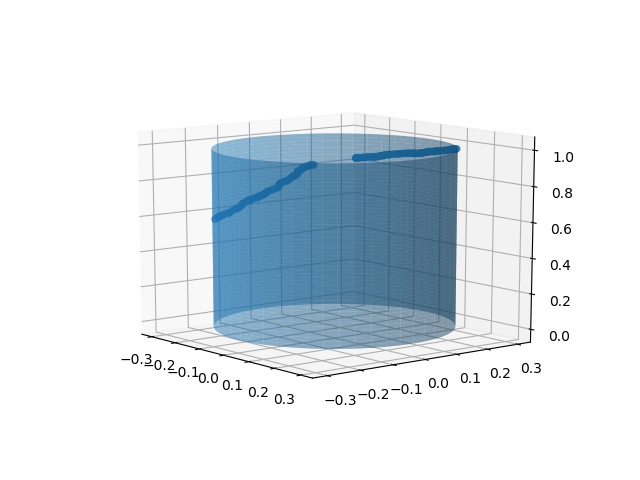

In [5]:
#########################################
## Generate a single event and plot it ##
#########################################

%matplotlib notebook
X, Y, Z, origin = reaction(KBeam,A,Z,Q,M,ExE,PxL,PyL,PzL,crossSections)
plot3D(X,Y,Z)

In [6]:
#####################################################
## Generate a data set for training and validation ##
#####################################################

generateNew = False # Set to true if you want to create a new data set. Set to false to load the
                    # data from data.dat and origins.dat which have 10000 generated events each.
                    # Warning: Can take ~15 min with 10000 samples (N) and 200 data points each.
if(generateNew):
    xList = []
    yList = []
    zList = []
    originList = []

    i = 0
    N = 10000
    minNumPoints = 200
    while(i < N):
        print("iteration = ",i+1)
        xTemp, yTemp, zTemp, originTemp = reaction(KBeam,A,Z,Q,M,ExE,PxL,PyL,PzL,crossSections)
        if(len(xTemp) > minNumPoints):
            xList.append(xTemp)
            yList.append(yTemp)
            zList.append(zTemp)
            originList.append(originTemp)
            i += 1

    minLen = 10000
    for i in range(N):
        if(minLen > len(xList[i])):
            minLen = len(xList[i])

    data = np.zeros((N,3,minLen))
    origin = np.zeros((N,3))

    for i in range(N):
        for j in range(minLen):
            data[i,0,j] = xList[i][j]
            data[i,1,j] = yList[i][j]
            data[i,2,j] = zList[i][j]
            if(j < 3):
                origin[i,j] = originList[i][j]
                
    data = np.reshape(data, (N,3*minLen))
    origin = origin / 1000
    
    np.savetxt("data.dat", data)
    np.savetxt("origins.dat", origin)
else:
    data = np.loadtxt("data.dat")
    origin = np.loadtxt("origins.dat")


iteration =  1
iteration =  2
iteration =  2
iteration =  2
iteration =  2
iteration =  2
iteration =  2
iteration =  2
iteration =  3
iteration =  3
iteration =  3
iteration =  3
iteration =  4
iteration =  4
iteration =  4
iteration =  4
iteration =  4
iteration =  5
iteration =  5
iteration =  6
iteration =  6
iteration =  6
iteration =  7
iteration =  7
iteration =  7
iteration =  7
iteration =  7
iteration =  7
iteration =  7
iteration =  8
iteration =  8
iteration =  9
iteration =  10
iteration =  10
iteration =  10
iteration =  11
iteration =  11
iteration =  11
iteration =  11
iteration =  11
iteration =  11
iteration =  12
iteration =  13
iteration =  13
iteration =  13
iteration =  14
iteration =  15
iteration =  15
iteration =  16
iteration =  16
iteration =  16
iteration =  17
iteration =  17
iteration =  17
iteration =  17
iteration =  17
iteration =  17
iteration =  18
iteration =  18
iteration =  19
iteration =  19
iteration =  19
iteration =  19
iteration =  20
iteratio

iteration =  168
iteration =  169
iteration =  170
iteration =  171
iteration =  171
iteration =  171
iteration =  172
iteration =  173
iteration =  173
iteration =  173
iteration =  173
iteration =  173
iteration =  173
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  174
iteration =  175
iteration =  175
iteration =  176
iteration =  176
iteration =  177
iteration =  177
iteration =  178
iteration =  179
iteration =  180
iteration =  181
iteration =  181
iteration =  181
iteration =  181
iteration =  182
iteration =  183
iteration =  184
iteration =  184
iteration =  184
iteration =  184
iteration =  184
iteration =  185
iteration =  185
iteration =  186
iteration =  186
iteration =  186
iteration =  186
iteration =  186
iteration =  186
iteration =  186
iteration =  187
iteration =  188
iteration =  1

iteration =  343
iteration =  343
iteration =  343
iteration =  343
iteration =  344
iteration =  344
iteration =  344
iteration =  344
iteration =  345
iteration =  345
iteration =  345
iteration =  345
iteration =  345
iteration =  345
iteration =  346
iteration =  347
iteration =  347
iteration =  347
iteration =  348
iteration =  348
iteration =  348
iteration =  348
iteration =  349
iteration =  349
iteration =  350
iteration =  350
iteration =  351
iteration =  351
iteration =  352
iteration =  353
iteration =  354
iteration =  354
iteration =  354
iteration =  354
iteration =  354
iteration =  355
iteration =  356
iteration =  356
iteration =  356
iteration =  357
iteration =  357
iteration =  358
iteration =  358
iteration =  359
iteration =  359
iteration =  360
iteration =  361
iteration =  361
iteration =  361
iteration =  361
iteration =  361
iteration =  361
iteration =  362
iteration =  362
iteration =  362
iteration =  362
iteration =  363
iteration =  363
iteration =  3

iteration =  539
iteration =  539
iteration =  540
iteration =  540
iteration =  540
iteration =  540
iteration =  541
iteration =  542
iteration =  542
iteration =  543
iteration =  543
iteration =  544
iteration =  544
iteration =  544
iteration =  545
iteration =  545
iteration =  545
iteration =  546
iteration =  546
iteration =  546
iteration =  547
iteration =  547
iteration =  548
iteration =  548
iteration =  548
iteration =  549
iteration =  550
iteration =  550
iteration =  550
iteration =  550
iteration =  550
iteration =  550
iteration =  550
iteration =  551
iteration =  551
iteration =  552
iteration =  552
iteration =  553
iteration =  553
iteration =  554
iteration =  554
iteration =  555
iteration =  555
iteration =  555
iteration =  556
iteration =  557
iteration =  558
iteration =  558
iteration =  559
iteration =  560
iteration =  560
iteration =  560
iteration =  560
iteration =  561
iteration =  562
iteration =  563
iteration =  563
iteration =  564
iteration =  5

iteration =  729
iteration =  729
iteration =  729
iteration =  730
iteration =  730
iteration =  731
iteration =  731
iteration =  732
iteration =  733
iteration =  734
iteration =  735
iteration =  735
iteration =  736
iteration =  736
iteration =  737
iteration =  738
iteration =  739
iteration =  739
iteration =  739
iteration =  740
iteration =  741
iteration =  741
iteration =  741
iteration =  741
iteration =  741
iteration =  741
iteration =  741
iteration =  741
iteration =  741
iteration =  742
iteration =  742
iteration =  743
iteration =  743
iteration =  743
iteration =  743
iteration =  744
iteration =  744
iteration =  744
iteration =  745
iteration =  745
iteration =  745
iteration =  745
iteration =  746
iteration =  747
iteration =  747
iteration =  748
iteration =  749
iteration =  749
iteration =  749
iteration =  749
iteration =  750
iteration =  750
iteration =  750
iteration =  751
iteration =  751
iteration =  752
iteration =  752
iteration =  753
iteration =  7

iteration =  909
iteration =  909
iteration =  909
iteration =  910
iteration =  910
iteration =  911
iteration =  911
iteration =  911
iteration =  911
iteration =  911
iteration =  912
iteration =  913
iteration =  913
iteration =  913
iteration =  913
iteration =  913
iteration =  914
iteration =  915
iteration =  915
iteration =  915
iteration =  915
iteration =  916
iteration =  916
iteration =  917
iteration =  917
iteration =  918
iteration =  918
iteration =  918
iteration =  918
iteration =  918
iteration =  918
iteration =  919
iteration =  920
iteration =  921
iteration =  921
iteration =  922
iteration =  922
iteration =  922
iteration =  922
iteration =  922
iteration =  923
iteration =  923
iteration =  923
iteration =  923
iteration =  924
iteration =  924
iteration =  924
iteration =  924
iteration =  924
iteration =  925
iteration =  925
iteration =  926
iteration =  926
iteration =  926
iteration =  927
iteration =  927
iteration =  927
iteration =  927
iteration =  9

iteration =  1090
iteration =  1090
iteration =  1091
iteration =  1092
iteration =  1092
iteration =  1093
iteration =  1093
iteration =  1094
iteration =  1094
iteration =  1095
iteration =  1096
iteration =  1096
iteration =  1096
iteration =  1096
iteration =  1097
iteration =  1097
iteration =  1097
iteration =  1097
iteration =  1098
iteration =  1099
iteration =  1100
iteration =  1100
iteration =  1101
iteration =  1101
iteration =  1101
iteration =  1101
iteration =  1101
iteration =  1102
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1103
iteration =  1104
iteration =  1104
iteration =  1105
iteration =  1105
iteration =  1106
iteration =  1106
iteration =  1107
iteration =  1107
iteration =  1108
iteration =  1108
iteration =  1108
iteration =  1108
iteration =  1109
iteration =  1109
iteration =  1110
iteration =  1110
iteration =  1110
iteration 

iteration =  1254
iteration =  1254
iteration =  1255
iteration =  1255
iteration =  1255
iteration =  1256
iteration =  1257
iteration =  1257
iteration =  1258
iteration =  1258
iteration =  1258
iteration =  1258
iteration =  1258
iteration =  1259
iteration =  1259
iteration =  1260
iteration =  1260
iteration =  1260
iteration =  1261
iteration =  1262
iteration =  1262
iteration =  1263
iteration =  1264
iteration =  1264
iteration =  1264
iteration =  1264
iteration =  1265
iteration =  1265
iteration =  1265
iteration =  1265
iteration =  1266
iteration =  1266
iteration =  1266
iteration =  1267
iteration =  1267
iteration =  1267
iteration =  1268
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1269
iteration =  1270
iteration =  1270
iteration =  1270
iteration =  1270
iteration =  1271
iteration =  1272
iteration =  1272
iteration =  1273
iteration 

iteration =  1429
iteration =  1429
iteration =  1430
iteration =  1430
iteration =  1430
iteration =  1431
iteration =  1431
iteration =  1431
iteration =  1431
iteration =  1432
iteration =  1432
iteration =  1432
iteration =  1433
iteration =  1433
iteration =  1433
iteration =  1433
iteration =  1434
iteration =  1434
iteration =  1434
iteration =  1434
iteration =  1434
iteration =  1434
iteration =  1434
iteration =  1435
iteration =  1435
iteration =  1435
iteration =  1435
iteration =  1435
iteration =  1436
iteration =  1436
iteration =  1436
iteration =  1436
iteration =  1436
iteration =  1437
iteration =  1437
iteration =  1438
iteration =  1439
iteration =  1440
iteration =  1441
iteration =  1442
iteration =  1442
iteration =  1442
iteration =  1443
iteration =  1443
iteration =  1443
iteration =  1443
iteration =  1443
iteration =  1444
iteration =  1444
iteration =  1445
iteration =  1445
iteration =  1445
iteration =  1446
iteration =  1447
iteration =  1448
iteration 

iteration =  1579
iteration =  1579
iteration =  1579
iteration =  1579
iteration =  1580
iteration =  1581
iteration =  1581
iteration =  1582
iteration =  1582
iteration =  1582
iteration =  1583
iteration =  1584
iteration =  1584
iteration =  1585
iteration =  1585
iteration =  1585
iteration =  1585
iteration =  1586
iteration =  1587
iteration =  1588
iteration =  1589
iteration =  1590
iteration =  1590
iteration =  1590
iteration =  1590
iteration =  1591
iteration =  1592
iteration =  1592
iteration =  1593
iteration =  1593
iteration =  1594
iteration =  1594
iteration =  1595
iteration =  1595
iteration =  1595
iteration =  1595
iteration =  1596
iteration =  1596
iteration =  1596
iteration =  1596
iteration =  1597
iteration =  1598
iteration =  1598
iteration =  1599
iteration =  1599
iteration =  1599
iteration =  1600
iteration =  1600
iteration =  1600
iteration =  1601
iteration =  1601
iteration =  1601
iteration =  1601
iteration =  1601
iteration =  1601
iteration 

iteration =  1753
iteration =  1753
iteration =  1754
iteration =  1754
iteration =  1754
iteration =  1755
iteration =  1755
iteration =  1755
iteration =  1755
iteration =  1755
iteration =  1756
iteration =  1757
iteration =  1758
iteration =  1758
iteration =  1758
iteration =  1759
iteration =  1760
iteration =  1760
iteration =  1760
iteration =  1760
iteration =  1760
iteration =  1760
iteration =  1761
iteration =  1762
iteration =  1763
iteration =  1763
iteration =  1763
iteration =  1763
iteration =  1763
iteration =  1764
iteration =  1764
iteration =  1765
iteration =  1766
iteration =  1766
iteration =  1766
iteration =  1766
iteration =  1766
iteration =  1767
iteration =  1768
iteration =  1768
iteration =  1769
iteration =  1769
iteration =  1769
iteration =  1770
iteration =  1770
iteration =  1771
iteration =  1771
iteration =  1772
iteration =  1773
iteration =  1774
iteration =  1775
iteration =  1775
iteration =  1775
iteration =  1775
iteration =  1776
iteration 

iteration =  1927
iteration =  1928
iteration =  1929
iteration =  1930
iteration =  1930
iteration =  1930
iteration =  1930
iteration =  1930
iteration =  1931
iteration =  1932
iteration =  1932
iteration =  1933
iteration =  1933
iteration =  1934
iteration =  1935
iteration =  1935
iteration =  1936
iteration =  1936
iteration =  1936
iteration =  1937
iteration =  1937
iteration =  1937
iteration =  1937
iteration =  1937
iteration =  1937
iteration =  1938
iteration =  1938
iteration =  1939
iteration =  1940
iteration =  1940
iteration =  1940
iteration =  1941
iteration =  1941
iteration =  1941
iteration =  1941
iteration =  1942
iteration =  1942
iteration =  1942
iteration =  1943
iteration =  1944
iteration =  1944
iteration =  1945
iteration =  1945
iteration =  1945
iteration =  1946
iteration =  1946
iteration =  1946
iteration =  1946
iteration =  1947
iteration =  1947
iteration =  1948
iteration =  1948
iteration =  1948
iteration =  1948
iteration =  1949
iteration 

iteration =  2113
iteration =  2114
iteration =  2114
iteration =  2114
iteration =  2115
iteration =  2116
iteration =  2117
iteration =  2117
iteration =  2117
iteration =  2117
iteration =  2117
iteration =  2118
iteration =  2118
iteration =  2119
iteration =  2120
iteration =  2120
iteration =  2120
iteration =  2121
iteration =  2121
iteration =  2122
iteration =  2123
iteration =  2123
iteration =  2123
iteration =  2123
iteration =  2123
iteration =  2124
iteration =  2124
iteration =  2124
iteration =  2124
iteration =  2125
iteration =  2125
iteration =  2125
iteration =  2125
iteration =  2126
iteration =  2126
iteration =  2126
iteration =  2127
iteration =  2127
iteration =  2127
iteration =  2127
iteration =  2127
iteration =  2127
iteration =  2127
iteration =  2127
iteration =  2127
iteration =  2128
iteration =  2128
iteration =  2128
iteration =  2128
iteration =  2129
iteration =  2129
iteration =  2129
iteration =  2129
iteration =  2129
iteration =  2130
iteration 

iteration =  2279
iteration =  2279
iteration =  2279
iteration =  2280
iteration =  2280
iteration =  2281
iteration =  2281
iteration =  2282
iteration =  2282
iteration =  2282
iteration =  2282
iteration =  2282
iteration =  2282
iteration =  2283
iteration =  2283
iteration =  2283
iteration =  2283
iteration =  2284
iteration =  2284
iteration =  2285
iteration =  2285
iteration =  2285
iteration =  2285
iteration =  2285
iteration =  2286
iteration =  2287
iteration =  2287
iteration =  2287
iteration =  2287
iteration =  2287
iteration =  2288
iteration =  2288
iteration =  2288
iteration =  2289
iteration =  2290
iteration =  2290
iteration =  2290
iteration =  2290
iteration =  2291
iteration =  2291
iteration =  2291
iteration =  2291
iteration =  2291
iteration =  2291
iteration =  2292
iteration =  2292
iteration =  2292
iteration =  2292
iteration =  2292
iteration =  2292
iteration =  2292
iteration =  2293
iteration =  2293
iteration =  2293
iteration =  2293
iteration 

iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2438
iteration =  2439
iteration =  2440
iteration =  2441
iteration =  2441
iteration =  2441
iteration =  2441
iteration =  2442
iteration =  2442
iteration =  2442
iteration =  2442
iteration =  2442
iteration =  2443
iteration =  2443
iteration =  2443
iteration =  2443
iteration =  2444
iteration =  2445
iteration =  2445
iteration =  2445
iteration =  2446
iteration =  2446
iteration =  2446
iteration =  2446
iteration =  2447
iteration =  2447
iteration =  2448
iteration =  2449
iteration =  2449
iteration =  2449
iteration =  2449
iteration =  2449
iteration =  2450
iteration =  2451
iteration =  2451
iteration =  2451
iteration =  2452
iteration =  2453
iteration =  2453
iteration =  2453
iteration =  2454
iteration =  2454
iteration =  2455
iteration 

iteration =  2591
iteration =  2592
iteration =  2593
iteration =  2593
iteration =  2594
iteration =  2594
iteration =  2594
iteration =  2595
iteration =  2595
iteration =  2596
iteration =  2596
iteration =  2596
iteration =  2596
iteration =  2596
iteration =  2597
iteration =  2597
iteration =  2597
iteration =  2598
iteration =  2598
iteration =  2598
iteration =  2598
iteration =  2598
iteration =  2598
iteration =  2598
iteration =  2598
iteration =  2599
iteration =  2599
iteration =  2600
iteration =  2600
iteration =  2601
iteration =  2602
iteration =  2603
iteration =  2604
iteration =  2605
iteration =  2606
iteration =  2607
iteration =  2607
iteration =  2608
iteration =  2608
iteration =  2609
iteration =  2609
iteration =  2609
iteration =  2609
iteration =  2609
iteration =  2609
iteration =  2609
iteration =  2609
iteration =  2609
iteration =  2610
iteration =  2610
iteration =  2610
iteration =  2610
iteration =  2611
iteration =  2611
iteration =  2612
iteration 

iteration =  2775
iteration =  2776
iteration =  2777
iteration =  2778
iteration =  2778
iteration =  2778
iteration =  2778
iteration =  2778
iteration =  2779
iteration =  2779
iteration =  2779
iteration =  2779
iteration =  2780
iteration =  2780
iteration =  2780
iteration =  2781
iteration =  2781
iteration =  2781
iteration =  2781
iteration =  2781
iteration =  2781
iteration =  2782
iteration =  2782
iteration =  2782
iteration =  2783
iteration =  2783
iteration =  2783
iteration =  2783
iteration =  2783
iteration =  2783
iteration =  2783
iteration =  2783
iteration =  2784
iteration =  2785
iteration =  2786
iteration =  2787
iteration =  2787
iteration =  2787
iteration =  2787
iteration =  2788
iteration =  2788
iteration =  2788
iteration =  2788
iteration =  2788
iteration =  2788
iteration =  2788
iteration =  2788
iteration =  2789
iteration =  2789
iteration =  2790
iteration =  2790
iteration =  2790
iteration =  2790
iteration =  2791
iteration =  2791
iteration 

iteration =  2943
iteration =  2944
iteration =  2944
iteration =  2945
iteration =  2945
iteration =  2945
iteration =  2946
iteration =  2946
iteration =  2947
iteration =  2947
iteration =  2948
iteration =  2949
iteration =  2950
iteration =  2951
iteration =  2951
iteration =  2952
iteration =  2952
iteration =  2952
iteration =  2953
iteration =  2954
iteration =  2954
iteration =  2955
iteration =  2956
iteration =  2956
iteration =  2957
iteration =  2957
iteration =  2957
iteration =  2958
iteration =  2958
iteration =  2959
iteration =  2960
iteration =  2960
iteration =  2960
iteration =  2960
iteration =  2961
iteration =  2961
iteration =  2961
iteration =  2962
iteration =  2963
iteration =  2963
iteration =  2964
iteration =  2965
iteration =  2966
iteration =  2966
iteration =  2966
iteration =  2967
iteration =  2967
iteration =  2967
iteration =  2968
iteration =  2968
iteration =  2969
iteration =  2969
iteration =  2969
iteration =  2969
iteration =  2970
iteration 

iteration =  3117
iteration =  3117
iteration =  3117
iteration =  3118
iteration =  3118
iteration =  3118
iteration =  3118
iteration =  3118
iteration =  3119
iteration =  3119
iteration =  3120
iteration =  3121
iteration =  3121
iteration =  3121
iteration =  3121
iteration =  3121
iteration =  3122
iteration =  3122
iteration =  3122
iteration =  3123
iteration =  3123
iteration =  3123
iteration =  3124
iteration =  3124
iteration =  3124
iteration =  3125
iteration =  3126
iteration =  3126
iteration =  3126
iteration =  3126
iteration =  3127
iteration =  3128
iteration =  3129
iteration =  3130
iteration =  3130
iteration =  3130
iteration =  3130
iteration =  3130
iteration =  3131
iteration =  3131
iteration =  3131
iteration =  3131
iteration =  3132
iteration =  3132
iteration =  3133
iteration =  3133
iteration =  3134
iteration =  3135
iteration =  3135
iteration =  3135
iteration =  3135
iteration =  3136
iteration =  3137
iteration =  3138
iteration =  3139
iteration 

iteration =  3278
iteration =  3278
iteration =  3278
iteration =  3278
iteration =  3278
iteration =  3278
iteration =  3279
iteration =  3280
iteration =  3280
iteration =  3280
iteration =  3281
iteration =  3281
iteration =  3282
iteration =  3282
iteration =  3283
iteration =  3283
iteration =  3283
iteration =  3284
iteration =  3284
iteration =  3284
iteration =  3284
iteration =  3285
iteration =  3285
iteration =  3285
iteration =  3285
iteration =  3285
iteration =  3285
iteration =  3286
iteration =  3286
iteration =  3287
iteration =  3288
iteration =  3288
iteration =  3288
iteration =  3289
iteration =  3289
iteration =  3289
iteration =  3289
iteration =  3289
iteration =  3290
iteration =  3291
iteration =  3291
iteration =  3292
iteration =  3292
iteration =  3293
iteration =  3293
iteration =  3294
iteration =  3295
iteration =  3296
iteration =  3297
iteration =  3297
iteration =  3298
iteration =  3298
iteration =  3299
iteration =  3299
iteration =  3299
iteration 

iteration =  3445
iteration =  3445
iteration =  3445
iteration =  3446
iteration =  3446
iteration =  3446
iteration =  3446
iteration =  3446
iteration =  3446
iteration =  3447
iteration =  3447
iteration =  3447
iteration =  3447
iteration =  3447
iteration =  3447
iteration =  3448
iteration =  3449
iteration =  3450
iteration =  3450
iteration =  3450
iteration =  3450
iteration =  3451
iteration =  3452
iteration =  3452
iteration =  3452
iteration =  3452
iteration =  3453
iteration =  3453
iteration =  3454
iteration =  3454
iteration =  3455
iteration =  3455
iteration =  3455
iteration =  3455
iteration =  3455
iteration =  3455
iteration =  3455
iteration =  3456
iteration =  3456
iteration =  3456
iteration =  3456
iteration =  3456
iteration =  3456
iteration =  3456
iteration =  3457
iteration =  3458
iteration =  3458
iteration =  3459
iteration =  3460
iteration =  3460
iteration =  3460
iteration =  3461
iteration =  3462
iteration =  3463
iteration =  3464
iteration 

iteration =  3612
iteration =  3613
iteration =  3613
iteration =  3614
iteration =  3615
iteration =  3616
iteration =  3616
iteration =  3616
iteration =  3616
iteration =  3616
iteration =  3617
iteration =  3618
iteration =  3618
iteration =  3619
iteration =  3619
iteration =  3620
iteration =  3621
iteration =  3621
iteration =  3621
iteration =  3621
iteration =  3622
iteration =  3623
iteration =  3623
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3624
iteration =  3625
iteration =  3625
iteration =  3626
iteration =  3626
iteration =  3626
iteration =  3626
iteration =  3626
iteration =  3627
iteration =  3627
iteration =  3627
iteration =  3628
iteration =  3628
iteration =  3628
iteration =  3629
iteration =  3630
iteration =  3630
iteration =  3630
iteration =  3631
iteration =  3631
iteration =  3631
iteration =  3632
iteration =  3633
iteration 

iteration =  3782
iteration =  3783
iteration =  3784
iteration =  3784
iteration =  3785
iteration =  3785
iteration =  3785
iteration =  3785
iteration =  3786
iteration =  3787
iteration =  3788
iteration =  3788
iteration =  3789
iteration =  3789
iteration =  3790
iteration =  3791
iteration =  3791
iteration =  3791
iteration =  3791
iteration =  3791
iteration =  3792
iteration =  3792
iteration =  3793
iteration =  3793
iteration =  3793
iteration =  3794
iteration =  3794
iteration =  3794
iteration =  3794
iteration =  3795
iteration =  3796
iteration =  3796
iteration =  3796
iteration =  3797
iteration =  3798
iteration =  3799
iteration =  3799
iteration =  3799
iteration =  3799
iteration =  3800
iteration =  3800
iteration =  3800
iteration =  3800
iteration =  3800
iteration =  3800
iteration =  3800
iteration =  3800
iteration =  3801
iteration =  3801
iteration =  3802
iteration =  3802
iteration =  3803
iteration =  3803
iteration =  3803
iteration =  3803
iteration 

iteration =  3975
iteration =  3975
iteration =  3975
iteration =  3975
iteration =  3975
iteration =  3976
iteration =  3976
iteration =  3976
iteration =  3977
iteration =  3977
iteration =  3977
iteration =  3977
iteration =  3977
iteration =  3978
iteration =  3979
iteration =  3979
iteration =  3979
iteration =  3979
iteration =  3980
iteration =  3980
iteration =  3980
iteration =  3981
iteration =  3982
iteration =  3983
iteration =  3983
iteration =  3983
iteration =  3984
iteration =  3984
iteration =  3984
iteration =  3984
iteration =  3985
iteration =  3985
iteration =  3986
iteration =  3987
iteration =  3988
iteration =  3988
iteration =  3989
iteration =  3990
iteration =  3990
iteration =  3991
iteration =  3991
iteration =  3992
iteration =  3992
iteration =  3992
iteration =  3993
iteration =  3993
iteration =  3994
iteration =  3994
iteration =  3995
iteration =  3996
iteration =  3997
iteration =  3997
iteration =  3998
iteration =  3999
iteration =  3999
iteration 

iteration =  4167
iteration =  4168
iteration =  4169
iteration =  4169
iteration =  4170
iteration =  4170
iteration =  4171
iteration =  4172
iteration =  4172
iteration =  4173
iteration =  4173
iteration =  4174
iteration =  4174
iteration =  4174
iteration =  4174
iteration =  4175
iteration =  4176
iteration =  4176
iteration =  4177
iteration =  4177
iteration =  4177
iteration =  4177
iteration =  4177
iteration =  4177
iteration =  4177
iteration =  4178
iteration =  4179
iteration =  4180
iteration =  4180
iteration =  4180
iteration =  4180
iteration =  4180
iteration =  4181
iteration =  4181
iteration =  4182
iteration =  4182
iteration =  4182
iteration =  4182
iteration =  4183
iteration =  4183
iteration =  4184
iteration =  4184
iteration =  4185
iteration =  4186
iteration =  4186
iteration =  4186
iteration =  4186
iteration =  4187
iteration =  4188
iteration =  4188
iteration =  4189
iteration =  4190
iteration =  4190
iteration =  4190
iteration =  4190
iteration 

iteration =  4334
iteration =  4334
iteration =  4334
iteration =  4335
iteration =  4335
iteration =  4335
iteration =  4335
iteration =  4336
iteration =  4336
iteration =  4337
iteration =  4338
iteration =  4338
iteration =  4338
iteration =  4338
iteration =  4339
iteration =  4339
iteration =  4340
iteration =  4340
iteration =  4340
iteration =  4340
iteration =  4340
iteration =  4341
iteration =  4341
iteration =  4341
iteration =  4341
iteration =  4342
iteration =  4343
iteration =  4344
iteration =  4345
iteration =  4346
iteration =  4346
iteration =  4346
iteration =  4347
iteration =  4347
iteration =  4347
iteration =  4347
iteration =  4347
iteration =  4347
iteration =  4347
iteration =  4348
iteration =  4349
iteration =  4350
iteration =  4351
iteration =  4352
iteration =  4353
iteration =  4354
iteration =  4354
iteration =  4354
iteration =  4354
iteration =  4355
iteration =  4355
iteration =  4355
iteration =  4355
iteration =  4355
iteration =  4355
iteration 

iteration =  4500
iteration =  4500
iteration =  4500
iteration =  4500
iteration =  4500
iteration =  4501
iteration =  4502
iteration =  4503
iteration =  4503
iteration =  4503
iteration =  4504
iteration =  4504
iteration =  4505
iteration =  4506
iteration =  4506
iteration =  4506
iteration =  4507
iteration =  4507
iteration =  4507
iteration =  4508
iteration =  4508
iteration =  4508
iteration =  4508
iteration =  4508
iteration =  4508
iteration =  4508
iteration =  4509
iteration =  4509
iteration =  4509
iteration =  4510
iteration =  4511
iteration =  4512
iteration =  4512
iteration =  4513
iteration =  4513
iteration =  4513
iteration =  4514
iteration =  4514
iteration =  4514
iteration =  4515
iteration =  4516
iteration =  4516
iteration =  4517
iteration =  4517
iteration =  4518
iteration =  4518
iteration =  4518
iteration =  4518
iteration =  4518
iteration =  4518
iteration =  4519
iteration =  4519
iteration =  4519
iteration =  4519
iteration =  4520
iteration 

iteration =  4665
iteration =  4665
iteration =  4666
iteration =  4666
iteration =  4666
iteration =  4666
iteration =  4667
iteration =  4667
iteration =  4667
iteration =  4667
iteration =  4667
iteration =  4668
iteration =  4668
iteration =  4669
iteration =  4669
iteration =  4670
iteration =  4671
iteration =  4672
iteration =  4672
iteration =  4672
iteration =  4673
iteration =  4674
iteration =  4674
iteration =  4675
iteration =  4676
iteration =  4677
iteration =  4677
iteration =  4678
iteration =  4679
iteration =  4679
iteration =  4680
iteration =  4680
iteration =  4680
iteration =  4680
iteration =  4680
iteration =  4680
iteration =  4680
iteration =  4680
iteration =  4680
iteration =  4681
iteration =  4681
iteration =  4681
iteration =  4681
iteration =  4682
iteration =  4682
iteration =  4683
iteration =  4684
iteration =  4684
iteration =  4684
iteration =  4685
iteration =  4685
iteration =  4685
iteration =  4686
iteration =  4686
iteration =  4687
iteration 

iteration =  4835
iteration =  4836
iteration =  4836
iteration =  4836
iteration =  4837
iteration =  4837
iteration =  4837
iteration =  4837
iteration =  4838
iteration =  4838
iteration =  4838
iteration =  4838
iteration =  4839
iteration =  4840
iteration =  4841
iteration =  4841
iteration =  4841
iteration =  4841
iteration =  4841
iteration =  4842
iteration =  4842
iteration =  4842
iteration =  4843
iteration =  4844
iteration =  4844
iteration =  4844
iteration =  4844
iteration =  4844
iteration =  4845
iteration =  4845
iteration =  4846
iteration =  4846
iteration =  4847
iteration =  4847
iteration =  4848
iteration =  4849
iteration =  4850
iteration =  4850
iteration =  4850
iteration =  4851
iteration =  4852
iteration =  4852
iteration =  4852
iteration =  4853
iteration =  4853
iteration =  4853
iteration =  4854
iteration =  4854
iteration =  4855
iteration =  4856
iteration =  4856
iteration =  4856
iteration =  4857
iteration =  4857
iteration =  4857
iteration 

iteration =  5002
iteration =  5003
iteration =  5003
iteration =  5003
iteration =  5004
iteration =  5004
iteration =  5005
iteration =  5005
iteration =  5006
iteration =  5006
iteration =  5006
iteration =  5006
iteration =  5007
iteration =  5007
iteration =  5008
iteration =  5009
iteration =  5010
iteration =  5011
iteration =  5012
iteration =  5012
iteration =  5012
iteration =  5013
iteration =  5014
iteration =  5014
iteration =  5014
iteration =  5014
iteration =  5015
iteration =  5016
iteration =  5016
iteration =  5016
iteration =  5017
iteration =  5017
iteration =  5018
iteration =  5018
iteration =  5019
iteration =  5020
iteration =  5021
iteration =  5021
iteration =  5022
iteration =  5022
iteration =  5023
iteration =  5024
iteration =  5025
iteration =  5025
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration =  5026
iteration 

iteration =  5171
iteration =  5171
iteration =  5172
iteration =  5172
iteration =  5172
iteration =  5172
iteration =  5172
iteration =  5172
iteration =  5173
iteration =  5174
iteration =  5174
iteration =  5174
iteration =  5174
iteration =  5174
iteration =  5174
iteration =  5174
iteration =  5175
iteration =  5175
iteration =  5175
iteration =  5176
iteration =  5177
iteration =  5177
iteration =  5177
iteration =  5178
iteration =  5178
iteration =  5179
iteration =  5179
iteration =  5180
iteration =  5180
iteration =  5181
iteration =  5181
iteration =  5181
iteration =  5181
iteration =  5182
iteration =  5183
iteration =  5184
iteration =  5184
iteration =  5185
iteration =  5186
iteration =  5187
iteration =  5187
iteration =  5187
iteration =  5187
iteration =  5187
iteration =  5188
iteration =  5188
iteration =  5188
iteration =  5188
iteration =  5188
iteration =  5188
iteration =  5188
iteration =  5188
iteration =  5189
iteration =  5190
iteration =  5191
iteration 

iteration =  5342
iteration =  5343
iteration =  5343
iteration =  5343
iteration =  5343
iteration =  5344
iteration =  5345
iteration =  5345
iteration =  5345
iteration =  5346
iteration =  5346
iteration =  5347
iteration =  5348
iteration =  5349
iteration =  5350
iteration =  5350
iteration =  5351
iteration =  5352
iteration =  5352
iteration =  5352
iteration =  5352
iteration =  5352
iteration =  5352
iteration =  5352
iteration =  5352
iteration =  5352
iteration =  5353
iteration =  5354
iteration =  5355
iteration =  5355
iteration =  5355
iteration =  5356
iteration =  5357
iteration =  5358
iteration =  5358
iteration =  5359
iteration =  5360
iteration =  5360
iteration =  5360
iteration =  5360
iteration =  5360
iteration =  5360
iteration =  5361
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5362
iteration =  5363
iteration 

iteration =  5528
iteration =  5528
iteration =  5528
iteration =  5528
iteration =  5528
iteration =  5528
iteration =  5528
iteration =  5529
iteration =  5529
iteration =  5530
iteration =  5530
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5531
iteration =  5532
iteration =  5532
iteration =  5532
iteration =  5532
iteration =  5533
iteration =  5533
iteration =  5534
iteration =  5534
iteration =  5534
iteration =  5535
iteration =  5535
iteration =  5535
iteration =  5535
iteration =  5535
iteration =  5536
iteration =  5536
iteration =  5537
iteration =  5538
iteration =  5539
iteration =  5539
iteration =  5539
iteration =  5539
iteration =  5540
iteration =  5540
iteration =  5540
iteration =  5540
iteration =  5540
iteration =  5541
iteration =  5541
iteration =  5542
iteration =  5543
iteration =  5543
iteration =  5543
iteration =  5543
iteration 

iteration =  5680
iteration =  5680
iteration =  5681
iteration =  5682
iteration =  5682
iteration =  5682
iteration =  5682
iteration =  5682
iteration =  5682
iteration =  5683
iteration =  5683
iteration =  5683
iteration =  5683
iteration =  5683
iteration =  5683
iteration =  5684
iteration =  5685
iteration =  5685
iteration =  5685
iteration =  5685
iteration =  5685
iteration =  5686
iteration =  5686
iteration =  5686
iteration =  5686
iteration =  5686
iteration =  5686
iteration =  5687
iteration =  5687
iteration =  5687
iteration =  5687
iteration =  5687
iteration =  5687
iteration =  5687
iteration =  5688
iteration =  5688
iteration =  5688
iteration =  5689
iteration =  5690
iteration =  5690
iteration =  5691
iteration =  5691
iteration =  5691
iteration =  5692
iteration =  5693
iteration =  5694
iteration =  5694
iteration =  5695
iteration =  5695
iteration =  5695
iteration =  5695
iteration =  5695
iteration =  5695
iteration =  5695
iteration =  5696
iteration 

iteration =  5830
iteration =  5830
iteration =  5830
iteration =  5830
iteration =  5830
iteration =  5830
iteration =  5831
iteration =  5831
iteration =  5831
iteration =  5831
iteration =  5831
iteration =  5832
iteration =  5833
iteration =  5833
iteration =  5833
iteration =  5834
iteration =  5834
iteration =  5835
iteration =  5835
iteration =  5835
iteration =  5835
iteration =  5836
iteration =  5836
iteration =  5837
iteration =  5838
iteration =  5838
iteration =  5839
iteration =  5839
iteration =  5840
iteration =  5840
iteration =  5841
iteration =  5841
iteration =  5841
iteration =  5841
iteration =  5842
iteration =  5843
iteration =  5843
iteration =  5844
iteration =  5845
iteration =  5845
iteration =  5846
iteration =  5846
iteration =  5847
iteration =  5847
iteration =  5847
iteration =  5847
iteration =  5847
iteration =  5848
iteration =  5849
iteration =  5850
iteration =  5851
iteration =  5851
iteration =  5852
iteration =  5853
iteration =  5853
iteration 

iteration =  6010
iteration =  6010
iteration =  6010
iteration =  6010
iteration =  6010
iteration =  6010
iteration =  6011
iteration =  6011
iteration =  6011
iteration =  6012
iteration =  6013
iteration =  6013
iteration =  6013
iteration =  6013
iteration =  6013
iteration =  6013
iteration =  6014
iteration =  6015
iteration =  6016
iteration =  6016
iteration =  6017
iteration =  6017
iteration =  6017
iteration =  6017
iteration =  6017
iteration =  6018
iteration =  6018
iteration =  6018
iteration =  6018
iteration =  6018
iteration =  6018
iteration =  6019
iteration =  6019
iteration =  6019
iteration =  6019
iteration =  6019
iteration =  6020
iteration =  6021
iteration =  6022
iteration =  6022
iteration =  6022
iteration =  6022
iteration =  6023
iteration =  6023
iteration =  6023
iteration =  6024
iteration =  6025
iteration =  6025
iteration =  6026
iteration =  6026
iteration =  6026
iteration =  6026
iteration =  6026
iteration =  6027
iteration =  6027
iteration 

iteration =  6175
iteration =  6176
iteration =  6177
iteration =  6177
iteration =  6177
iteration =  6177
iteration =  6178
iteration =  6179
iteration =  6179
iteration =  6180
iteration =  6181
iteration =  6181
iteration =  6181
iteration =  6181
iteration =  6182
iteration =  6183
iteration =  6183
iteration =  6183
iteration =  6184
iteration =  6184
iteration =  6184
iteration =  6185
iteration =  6186
iteration =  6186
iteration =  6186
iteration =  6187
iteration =  6187
iteration =  6188
iteration =  6189
iteration =  6189
iteration =  6189
iteration =  6189
iteration =  6190
iteration =  6190
iteration =  6191
iteration =  6192
iteration =  6192
iteration =  6192
iteration =  6192
iteration =  6192
iteration =  6192
iteration =  6193
iteration =  6193
iteration =  6193
iteration =  6194
iteration =  6194
iteration =  6195
iteration =  6195
iteration =  6196
iteration =  6196
iteration =  6197
iteration =  6198
iteration =  6198
iteration =  6198
iteration =  6199
iteration 

iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6354
iteration =  6355
iteration =  6356
iteration =  6356
iteration =  6356
iteration =  6357
iteration =  6358
iteration =  6358
iteration =  6359
iteration =  6359
iteration =  6359
iteration =  6360
iteration =  6361
iteration =  6361
iteration =  6361
iteration =  6361
iteration =  6361
iteration =  6361
iteration =  6362
iteration =  6362
iteration =  6363
iteration =  6363
iteration =  6364
iteration =  6364
iteration =  6364
iteration =  6365
iteration =  6365
iteration =  6366
iteration =  6366
iteration =  6366
iteration =  6366
iteration =  6366
iteration =  6367
iteration =  6367
iteration =  6368
iteration =  6368
iteration =  6368
iteration =  6368
iteration =  6368
iteration =  6368
iteration =  6368
iteration =  6368
iteration =  6369
iteration =  6369
iteration =  6369
iteration 

iteration =  6496
iteration =  6497
iteration =  6497
iteration =  6497
iteration =  6498
iteration =  6498
iteration =  6498
iteration =  6498
iteration =  6498
iteration =  6498
iteration =  6499
iteration =  6500
iteration =  6500
iteration =  6501
iteration =  6501
iteration =  6501
iteration =  6502
iteration =  6502
iteration =  6502
iteration =  6502
iteration =  6502
iteration =  6502
iteration =  6503
iteration =  6504
iteration =  6504
iteration =  6504
iteration =  6504
iteration =  6504
iteration =  6505
iteration =  6505
iteration =  6506
iteration =  6506
iteration =  6506
iteration =  6507
iteration =  6507
iteration =  6507
iteration =  6507
iteration =  6507
iteration =  6508
iteration =  6509
iteration =  6510
iteration =  6511
iteration =  6511
iteration =  6512
iteration =  6513
iteration =  6514
iteration =  6515
iteration =  6515
iteration =  6515
iteration =  6515
iteration =  6515
iteration =  6515
iteration =  6516
iteration =  6517
iteration =  6517
iteration 

iteration =  6657
iteration =  6657
iteration =  6657
iteration =  6657
iteration =  6657
iteration =  6657
iteration =  6658
iteration =  6658
iteration =  6658
iteration =  6658
iteration =  6659
iteration =  6659
iteration =  6660
iteration =  6660
iteration =  6661
iteration =  6661
iteration =  6662
iteration =  6662
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6663
iteration =  6664
iteration =  6664
iteration =  6664
iteration =  6664
iteration =  6665
iteration =  6665
iteration =  6665
iteration =  6666
iteration =  6666
iteration =  6666
iteration =  6666
iteration =  6667
iteration =  6667
iteration =  6667
iteration =  6667
iteration =  6667
iteration =  6668
iteration =  6669
iteration =  6669
iteration =  6669
iteration =  6670
iteration =  6670
iteration =  6670
iteration =  6670
iteration =  6671
iteration 

iteration =  6814
iteration =  6814
iteration =  6814
iteration =  6814
iteration =  6814
iteration =  6814
iteration =  6815
iteration =  6815
iteration =  6815
iteration =  6816
iteration =  6816
iteration =  6816
iteration =  6817
iteration =  6818
iteration =  6818
iteration =  6818
iteration =  6819
iteration =  6819
iteration =  6820
iteration =  6820
iteration =  6821
iteration =  6821
iteration =  6821
iteration =  6822
iteration =  6823
iteration =  6824
iteration =  6824
iteration =  6824
iteration =  6824
iteration =  6825
iteration =  6825
iteration =  6825
iteration =  6826
iteration =  6826
iteration =  6826
iteration =  6827
iteration =  6828
iteration =  6829
iteration =  6829
iteration =  6829
iteration =  6830
iteration =  6830
iteration =  6831
iteration =  6832
iteration =  6832
iteration =  6832
iteration =  6833
iteration =  6834
iteration =  6834
iteration =  6835
iteration =  6836
iteration =  6836
iteration =  6836
iteration =  6837
iteration =  6837
iteration 

iteration =  6977
iteration =  6978
iteration =  6978
iteration =  6978
iteration =  6978
iteration =  6979
iteration =  6979
iteration =  6980
iteration =  6980
iteration =  6981
iteration =  6981
iteration =  6982
iteration =  6982
iteration =  6982
iteration =  6982
iteration =  6982
iteration =  6982
iteration =  6982
iteration =  6983
iteration =  6983
iteration =  6984
iteration =  6984
iteration =  6984
iteration =  6985
iteration =  6986
iteration =  6986
iteration =  6987
iteration =  6987
iteration =  6987
iteration =  6988
iteration =  6989
iteration =  6989
iteration =  6990
iteration =  6990
iteration =  6990
iteration =  6991
iteration =  6992
iteration =  6993
iteration =  6993
iteration =  6994
iteration =  6994
iteration =  6994
iteration =  6995
iteration =  6995
iteration =  6995
iteration =  6996
iteration =  6997
iteration =  6997
iteration =  6998
iteration =  6999
iteration =  6999
iteration =  6999
iteration =  7000
iteration =  7000
iteration =  7001
iteration 

iteration =  7146
iteration =  7146
iteration =  7146
iteration =  7147
iteration =  7148
iteration =  7148
iteration =  7149
iteration =  7150
iteration =  7151
iteration =  7151
iteration =  7151
iteration =  7152
iteration =  7152
iteration =  7152
iteration =  7153
iteration =  7153
iteration =  7153
iteration =  7153
iteration =  7154
iteration =  7155
iteration =  7155
iteration =  7155
iteration =  7155
iteration =  7155
iteration =  7156
iteration =  7157
iteration =  7157
iteration =  7157
iteration =  7158
iteration =  7159
iteration =  7159
iteration =  7160
iteration =  7160
iteration =  7161
iteration =  7162
iteration =  7163
iteration =  7164
iteration =  7164
iteration =  7164
iteration =  7165
iteration =  7165
iteration =  7166
iteration =  7166
iteration =  7166
iteration =  7166
iteration =  7166
iteration =  7167
iteration =  7168
iteration =  7168
iteration =  7168
iteration =  7168
iteration =  7168
iteration =  7169
iteration =  7169
iteration =  7169
iteration 

iteration =  7326
iteration =  7326
iteration =  7327
iteration =  7327
iteration =  7328
iteration =  7328
iteration =  7329
iteration =  7330
iteration =  7330
iteration =  7330
iteration =  7330
iteration =  7331
iteration =  7331
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7332
iteration =  7333
iteration =  7334
iteration =  7334
iteration =  7335
iteration =  7336
iteration =  7337
iteration =  7337
iteration =  7338
iteration =  7338
iteration =  7338
iteration =  7338
iteration =  7339
iteration =  7339
iteration =  7339
iteration =  7339
iteration =  7339
iteration =  7339
iteration =  7339
iteration =  7340
iteration =  7340
iteration =  7341
iteration =  7342
iteration =  7343
iteration =  7344
iteration =  7344
iteration =  7345
iteration =  7345
iteration =  7345
iteration =  7345
iteration =  7345
iteration =  7346
iteration =  7347
iteration 

iteration =  7487
iteration =  7487
iteration =  7488
iteration =  7488
iteration =  7489
iteration =  7490
iteration =  7491
iteration =  7491
iteration =  7491
iteration =  7492
iteration =  7493
iteration =  7493
iteration =  7494
iteration =  7494
iteration =  7494
iteration =  7494
iteration =  7494
iteration =  7495
iteration =  7496
iteration =  7497
iteration =  7497
iteration =  7498
iteration =  7499
iteration =  7499
iteration =  7499
iteration =  7499
iteration =  7499
iteration =  7500
iteration =  7501
iteration =  7501
iteration =  7501
iteration =  7501
iteration =  7501
iteration =  7501
iteration =  7501
iteration =  7502
iteration =  7502
iteration =  7502
iteration =  7502
iteration =  7502
iteration =  7502
iteration =  7502
iteration =  7503
iteration =  7504
iteration =  7504
iteration =  7504
iteration =  7504
iteration =  7504
iteration =  7505
iteration =  7505
iteration =  7505
iteration =  7506
iteration =  7506
iteration =  7506
iteration =  7507
iteration 

iteration =  7656
iteration =  7656
iteration =  7657
iteration =  7657
iteration =  7657
iteration =  7658
iteration =  7658
iteration =  7659
iteration =  7659
iteration =  7659
iteration =  7659
iteration =  7660
iteration =  7660
iteration =  7661
iteration =  7662
iteration =  7662
iteration =  7662
iteration =  7663
iteration =  7663
iteration =  7663
iteration =  7663
iteration =  7664
iteration =  7664
iteration =  7665
iteration =  7665
iteration =  7666
iteration =  7666
iteration =  7666
iteration =  7666
iteration =  7666
iteration =  7666
iteration =  7666
iteration =  7667
iteration =  7668
iteration =  7668
iteration =  7668
iteration =  7669
iteration =  7670
iteration =  7670
iteration =  7671
iteration =  7671
iteration =  7672
iteration =  7672
iteration =  7672
iteration =  7672
iteration =  7673
iteration =  7674
iteration =  7675
iteration =  7675
iteration =  7675
iteration =  7675
iteration =  7675
iteration =  7675
iteration =  7676
iteration =  7676
iteration 

iteration =  7841
iteration =  7842
iteration =  7842
iteration =  7842
iteration =  7842
iteration =  7842
iteration =  7843
iteration =  7843
iteration =  7843
iteration =  7844
iteration =  7844
iteration =  7845
iteration =  7846
iteration =  7846
iteration =  7846
iteration =  7847
iteration =  7847
iteration =  7848
iteration =  7848
iteration =  7848
iteration =  7848
iteration =  7848
iteration =  7848
iteration =  7849
iteration =  7849
iteration =  7850
iteration =  7850
iteration =  7850
iteration =  7851
iteration =  7851
iteration =  7851
iteration =  7851
iteration =  7852
iteration =  7852
iteration =  7853
iteration =  7853
iteration =  7853
iteration =  7853
iteration =  7854
iteration =  7855
iteration =  7856
iteration =  7856
iteration =  7856
iteration =  7856
iteration =  7857
iteration =  7858
iteration =  7858
iteration =  7859
iteration =  7859
iteration =  7860
iteration =  7861
iteration =  7862
iteration =  7862
iteration =  7862
iteration =  7863
iteration 

iteration =  7996
iteration =  7996
iteration =  7996
iteration =  7996
iteration =  7996
iteration =  7996
iteration =  7996
iteration =  7996
iteration =  7997
iteration =  7998
iteration =  7998
iteration =  7999
iteration =  7999
iteration =  7999
iteration =  7999
iteration =  7999
iteration =  8000
iteration =  8001
iteration =  8001
iteration =  8002
iteration =  8002
iteration =  8002
iteration =  8002
iteration =  8003
iteration =  8003
iteration =  8004
iteration =  8004
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8005
iteration =  8006
iteration =  8006
iteration =  8006
iteration =  8006
iteration =  8007
iteration =  8008
iteration =  8008
iteration =  8008
iteration =  8008
iteration =  8008
iteration =  8009
iteration =  8009
iteration =  8009
iteration =  8009
iteration =  8010
iteration =  8010
iteration =  8011
iteration =  8012
iteration 

iteration =  8163
iteration =  8164
iteration =  8164
iteration =  8164
iteration =  8165
iteration =  8166
iteration =  8166
iteration =  8166
iteration =  8166
iteration =  8167
iteration =  8167
iteration =  8167
iteration =  8167
iteration =  8167
iteration =  8167
iteration =  8167
iteration =  8167
iteration =  8168
iteration =  8168
iteration =  8168
iteration =  8169
iteration =  8169
iteration =  8170
iteration =  8170
iteration =  8170
iteration =  8170
iteration =  8170
iteration =  8170
iteration =  8171
iteration =  8171
iteration =  8171
iteration =  8171
iteration =  8172
iteration =  8172
iteration =  8172
iteration =  8173
iteration =  8174
iteration =  8175
iteration =  8176
iteration =  8176
iteration =  8176
iteration =  8176
iteration =  8177
iteration =  8178
iteration =  8179
iteration =  8179
iteration =  8180
iteration =  8181
iteration =  8181
iteration =  8181
iteration =  8181
iteration =  8182
iteration =  8183
iteration =  8184
iteration =  8185
iteration 

iteration =  8327
iteration =  8328
iteration =  8328
iteration =  8329
iteration =  8330
iteration =  8330
iteration =  8331
iteration =  8332
iteration =  8332
iteration =  8332
iteration =  8332
iteration =  8333
iteration =  8333
iteration =  8334
iteration =  8335
iteration =  8335
iteration =  8335
iteration =  8335
iteration =  8335
iteration =  8335
iteration =  8335
iteration =  8336
iteration =  8336
iteration =  8336
iteration =  8336
iteration =  8336
iteration =  8336
iteration =  8337
iteration =  8337
iteration =  8337
iteration =  8337
iteration =  8338
iteration =  8338
iteration =  8338
iteration =  8339
iteration =  8339
iteration =  8340
iteration =  8341
iteration =  8341
iteration =  8341
iteration =  8341
iteration =  8342
iteration =  8343
iteration =  8343
iteration =  8343
iteration =  8343
iteration =  8343
iteration =  8343
iteration =  8344
iteration =  8344
iteration =  8344
iteration =  8344
iteration =  8344
iteration =  8345
iteration =  8345
iteration 

iteration =  8481
iteration =  8481
iteration =  8481
iteration =  8482
iteration =  8483
iteration =  8484
iteration =  8485
iteration =  8485
iteration =  8486
iteration =  8486
iteration =  8487
iteration =  8487
iteration =  8487
iteration =  8487
iteration =  8488
iteration =  8488
iteration =  8489
iteration =  8490
iteration =  8490
iteration =  8490
iteration =  8490
iteration =  8491
iteration =  8491
iteration =  8492
iteration =  8492
iteration =  8492
iteration =  8492
iteration =  8493
iteration =  8493
iteration =  8493
iteration =  8494
iteration =  8494
iteration =  8494
iteration =  8495
iteration =  8496
iteration =  8497
iteration =  8498
iteration =  8498
iteration =  8498
iteration =  8499
iteration =  8500
iteration =  8501
iteration =  8501
iteration =  8502
iteration =  8502
iteration =  8502
iteration =  8502
iteration =  8502
iteration =  8503
iteration =  8503
iteration =  8504
iteration =  8504
iteration =  8504
iteration =  8505
iteration =  8506
iteration 

iteration =  8658
iteration =  8659
iteration =  8659
iteration =  8660
iteration =  8660
iteration =  8660
iteration =  8660
iteration =  8660
iteration =  8660
iteration =  8660
iteration =  8660
iteration =  8661
iteration =  8661
iteration =  8661
iteration =  8661
iteration =  8662
iteration =  8662
iteration =  8662
iteration =  8663
iteration =  8664
iteration =  8664
iteration =  8664
iteration =  8664
iteration =  8664
iteration =  8664
iteration =  8664
iteration =  8665
iteration =  8665
iteration =  8665
iteration =  8665
iteration =  8666
iteration =  8666
iteration =  8667
iteration =  8667
iteration =  8667
iteration =  8667
iteration =  8668
iteration =  8668
iteration =  8669
iteration =  8669
iteration =  8669
iteration =  8669
iteration =  8670
iteration =  8670
iteration =  8670
iteration =  8670
iteration =  8671
iteration =  8671
iteration =  8671
iteration =  8671
iteration =  8671
iteration =  8671
iteration =  8671
iteration =  8672
iteration =  8672
iteration 

iteration =  8806
iteration =  8807
iteration =  8807
iteration =  8808
iteration =  8808
iteration =  8808
iteration =  8808
iteration =  8808
iteration =  8808
iteration =  8809
iteration =  8810
iteration =  8810
iteration =  8810
iteration =  8811
iteration =  8811
iteration =  8811
iteration =  8811
iteration =  8812
iteration =  8813
iteration =  8814
iteration =  8814
iteration =  8814
iteration =  8814
iteration =  8814
iteration =  8814
iteration =  8815
iteration =  8816
iteration =  8817
iteration =  8817
iteration =  8818
iteration =  8819
iteration =  8820
iteration =  8821
iteration =  8821
iteration =  8821
iteration =  8821
iteration =  8821
iteration =  8821
iteration =  8822
iteration =  8823
iteration =  8823
iteration =  8824
iteration =  8824
iteration =  8824
iteration =  8824
iteration =  8824
iteration =  8824
iteration =  8824
iteration =  8824
iteration =  8825
iteration =  8826
iteration =  8827
iteration =  8827
iteration =  8827
iteration =  8827
iteration 

iteration =  8973
iteration =  8973
iteration =  8974
iteration =  8974
iteration =  8974
iteration =  8974
iteration =  8975
iteration =  8975
iteration =  8976
iteration =  8976
iteration =  8976
iteration =  8977
iteration =  8978
iteration =  8978
iteration =  8979
iteration =  8979
iteration =  8980
iteration =  8980
iteration =  8980
iteration =  8980
iteration =  8980
iteration =  8981
iteration =  8981
iteration =  8981
iteration =  8982
iteration =  8982
iteration =  8983
iteration =  8983
iteration =  8983
iteration =  8984
iteration =  8985
iteration =  8985
iteration =  8985
iteration =  8985
iteration =  8985
iteration =  8986
iteration =  8986
iteration =  8986
iteration =  8987
iteration =  8988
iteration =  8989
iteration =  8989
iteration =  8989
iteration =  8989
iteration =  8989
iteration =  8990
iteration =  8991
iteration =  8992
iteration =  8992
iteration =  8992
iteration =  8992
iteration =  8992
iteration =  8992
iteration =  8993
iteration =  8993
iteration 

iteration =  9133
iteration =  9134
iteration =  9134
iteration =  9134
iteration =  9135
iteration =  9135
iteration =  9135
iteration =  9136
iteration =  9137
iteration =  9137
iteration =  9138
iteration =  9138
iteration =  9138
iteration =  9139
iteration =  9139
iteration =  9139
iteration =  9139
iteration =  9139
iteration =  9140
iteration =  9141
iteration =  9141
iteration =  9141
iteration =  9141
iteration =  9142
iteration =  9142
iteration =  9142
iteration =  9143
iteration =  9143
iteration =  9143
iteration =  9144
iteration =  9144
iteration =  9145
iteration =  9145
iteration =  9146
iteration =  9146
iteration =  9147
iteration =  9147
iteration =  9147
iteration =  9147
iteration =  9147
iteration =  9148
iteration =  9148
iteration =  9149
iteration =  9149
iteration =  9149
iteration =  9150
iteration =  9150
iteration =  9150
iteration =  9150
iteration =  9150
iteration =  9150
iteration =  9151
iteration =  9151
iteration =  9151
iteration =  9152
iteration 

iteration =  9289
iteration =  9289
iteration =  9289
iteration =  9289
iteration =  9290
iteration =  9291
iteration =  9292
iteration =  9293
iteration =  9294
iteration =  9294
iteration =  9294
iteration =  9294
iteration =  9295
iteration =  9295
iteration =  9296
iteration =  9296
iteration =  9296
iteration =  9296
iteration =  9296
iteration =  9296
iteration =  9297
iteration =  9297
iteration =  9297
iteration =  9297
iteration =  9298
iteration =  9298
iteration =  9298
iteration =  9299
iteration =  9299
iteration =  9299
iteration =  9299
iteration =  9299
iteration =  9299
iteration =  9300
iteration =  9301
iteration =  9302
iteration =  9302
iteration =  9302
iteration =  9303
iteration =  9304
iteration =  9304
iteration =  9304
iteration =  9304
iteration =  9305
iteration =  9306
iteration =  9307
iteration =  9308
iteration =  9308
iteration =  9308
iteration =  9309
iteration =  9309
iteration =  9310
iteration =  9310
iteration =  9310
iteration =  9310
iteration 

iteration =  9459
iteration =  9460
iteration =  9460
iteration =  9460
iteration =  9460
iteration =  9460
iteration =  9460
iteration =  9460
iteration =  9460
iteration =  9460
iteration =  9461
iteration =  9461
iteration =  9461
iteration =  9461
iteration =  9461
iteration =  9461
iteration =  9461
iteration =  9461
iteration =  9462
iteration =  9462
iteration =  9463
iteration =  9463
iteration =  9463
iteration =  9464
iteration =  9464
iteration =  9464
iteration =  9465
iteration =  9466
iteration =  9466
iteration =  9466
iteration =  9466
iteration =  9466
iteration =  9467
iteration =  9468
iteration =  9468
iteration =  9469
iteration =  9469
iteration =  9470
iteration =  9470
iteration =  9470
iteration =  9470
iteration =  9471
iteration =  9472
iteration =  9473
iteration =  9473
iteration =  9474
iteration =  9474
iteration =  9474
iteration =  9475
iteration =  9475
iteration =  9475
iteration =  9475
iteration =  9475
iteration =  9475
iteration =  9475
iteration 

iteration =  9632
iteration =  9632
iteration =  9632
iteration =  9632
iteration =  9633
iteration =  9633
iteration =  9633
iteration =  9633
iteration =  9633
iteration =  9634
iteration =  9635
iteration =  9636
iteration =  9636
iteration =  9636
iteration =  9637
iteration =  9638
iteration =  9638
iteration =  9638
iteration =  9639
iteration =  9639
iteration =  9640
iteration =  9640
iteration =  9641
iteration =  9641
iteration =  9641
iteration =  9641
iteration =  9641
iteration =  9642
iteration =  9643
iteration =  9643
iteration =  9644
iteration =  9644
iteration =  9644
iteration =  9644
iteration =  9644
iteration =  9645
iteration =  9645
iteration =  9646
iteration =  9646
iteration =  9647
iteration =  9647
iteration =  9647
iteration =  9648
iteration =  9649
iteration =  9649
iteration =  9649
iteration =  9650
iteration =  9650
iteration =  9650
iteration =  9650
iteration =  9650
iteration =  9650
iteration =  9651
iteration =  9651
iteration =  9651
iteration 

iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9800
iteration =  9801
iteration =  9802
iteration =  9802
iteration =  9803
iteration =  9803
iteration =  9803
iteration =  9804
iteration =  9804
iteration =  9805
iteration =  9805
iteration =  9806
iteration =  9807
iteration =  9807
iteration =  9808
iteration =  9808
iteration =  9809
iteration =  9809
iteration =  9810
iteration =  9810
iteration =  9810
iteration =  9810
iteration =  9811
iteration =  9811
iteration =  9812
iteration =  9813
iteration =  9814
iteration =  9814
iteration =  9814
iteration =  9814
iteration =  9815
iteration =  9816
iteration =  9816
iteration =  9816
iteration =  9817
iteration =  9817
iteration =  9817
iteration =  9817
iteration =  9817
iteration =  9817
iteration =  9817
iteration =  9817
iteration 

iteration =  9959
iteration =  9959
iteration =  9959
iteration =  9959
iteration =  9959
iteration =  9959
iteration =  9959
iteration =  9960
iteration =  9960
iteration =  9960
iteration =  9960
iteration =  9961
iteration =  9962
iteration =  9963
iteration =  9964
iteration =  9965
iteration =  9966
iteration =  9966
iteration =  9966
iteration =  9967
iteration =  9968
iteration =  9969
iteration =  9969
iteration =  9969
iteration =  9969
iteration =  9970
iteration =  9971
iteration =  9971
iteration =  9971
iteration =  9971
iteration =  9971
iteration =  9971
iteration =  9972
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9973
iteration =  9974
iteration =  9975
iteration =  9975
iteration =  9975
iteration =  9976
iteration =  9977
iteration =  9977
iteration =  9977
iteration =  9977
iteration =  9977
iteration =  9978
iteration 

***
## Fitting with a Neural Network ##

**The type of network being used is a feedforward fully connected network (FCN), which is implemented using Keras' Sequential class. The input data is an N by M array, where N corresponds to the 10000 samples and M corresponds to three times (since there are 3 coordinates) the number of points drawn in the trajectories. The output is an array of three values each corresponding to the spatial location of the reaction point.**

In [7]:
############################################################
## Split data into training, testing, and validation sets ##
############################################################

dataTrain, dataVal, originTrain, originVal = train_test_split(np.array(data), np.array(origin), test_size=1000, random_state=0)


In [8]:
###################################################
## First we instantiate the Neural Network model ##
###################################################

model = Sequential() # <== fill the blank


# Next we add the first two layers. Dense means that is fully connected, 
# the input layer has size 603= 3x201 (three dimensions and 201 points), 
# and the second layer has 5 units. A bias term can be added by including bias=True
# the activation function is a sigmoid, but this can be changed.
model.add(Dense( 50 , input_dim= 603 , activation= 'sigmoid' , use_bias= True)) # <== fill the blank


# More hidden layers can be added here using model.add(Dense(n_nodes= , activation = ' ', bias=  ))


# The output layer has three units, one for each dimnesion, 
# and the activation functions are sigmoids. 
# Notice that different layers can have different activation functions.
model.add(Dense( 3 , activation= 'sigmoid' , use_bias= True)) # <== fill the blank


# The type of minimization algorithm we will use is stochastic gradient descent (SGD) 
# with learning rate = 0.1.
sgd = SGD(lr=1)


# Finally, we form the model to be trained. Let's use mean squared error to evaluate the 
# loss function.
model.compile(loss= 'mse' , optimizer=sgd, metrics=['accuracy']) # <== fill the blank


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
####################################################################
## Custom callback, to see what's going on while training happens ##
####################################################################

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.accuracies.append(logs.get("acc"))
        
history = LossHistory()

In [10]:
#####################
## Train the model ##
#####################

model.fit(dataTrain, originTrain, batch_size=100, nb_epoch=10, shuffle=True, validation_data=(dataVal, originVal), callbacks=[history])

Instructions for updating:
Use tf.cast instead.


C:\Users\alexc\Anaconda3\envs\kerasenv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 28us/step - loss: 0.0161 - acc: 0.8923 - val_loss: 0.0081 - val_acc: 0.9150
Epoch 2/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.0067 - acc: 0.9269 - val_loss: 0.0062 - val_acc: 0.9180
Epoch 3/10
9000/9000 [==============================] - 0s 15us/step - loss: 0.0055 - acc: 0.9274 - val_loss: 0.0053 - val_acc: 0.9210
Epoch 4/10
9000/9000 [==============================] - 0s 15us/step - loss: 0.0048 - acc: 0.9241 - val_loss: 0.0047 - val_acc: 0.9130
Epoch 5/10
9000/9000 [==============================] - 0s 16us/step - loss: 0.0043 - acc: 0.9184 - val_loss: 0.0043 - val_acc: 0.9100
Epoch 6/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.0040 - acc: 0.9112 - val_loss: 0.0040 - val_acc: 0.9090
Epoch 7/10
9000/9000 [==============================] - 0s 14us/step - loss: 0.0038 - acc: 0.9097 - val_loss: 0.0038 - val_acc: 0.9060
Epoch 8

<IPython.core.display.Javascript object>


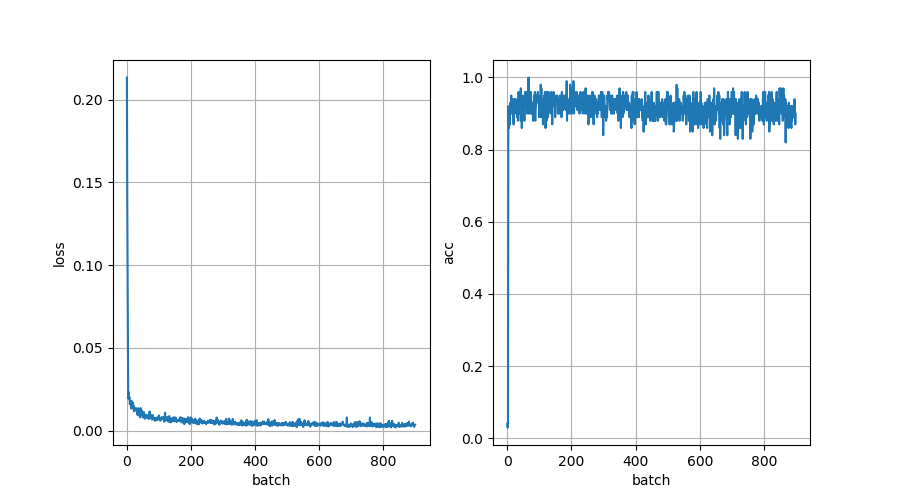

In [11]:
################################################
## Plot how the loss (mean squared error) and ##
## accuracy changed as training went on       ##
################################################

plt.figure(1,figsize=(9, 5))
plt.subplot(121)
plt.plot(range(len(history.losses)), history.losses)
plt.xlabel("batch")
plt.ylabel("loss")
plt.grid()

plt.subplot(122)
plt.plot(range(len(history.accuracies)), history.accuracies)
plt.xlabel("batch")
plt.ylabel("acc")
plt.grid()


plt.show()

In [14]:
#####################################
## Generate a data set for testing ##
#####################################

generateNew = False # Set to True if you want to create a new data set. Set to False to load the data
                   # from testData.dat and testOrigins.dat which have 1000 generated events in each.
if(generateNew):
    xList = []
    yList = []
    zList = []
    originList = []

    i = 0
    N = 1000
    minNumPoints = 200
    while(i < N):
        print("iteration = ",i+1)
        xTemp, yTemp, zTemp, originTemp = reaction(KBeam,A,Z,Q,M,ExE,PxL,PyL,PzL,crossSections)
        if(len(xTemp) > minNumPoints):
            xList.append(xTemp)
            yList.append(yTemp)
            zList.append(zTemp)
            originList.append(originTemp)
            i += 1

    minLen = 10000
    for i in range(N):
        if(minLen > len(xList[i])):
            minLen = len(xList[i])

    dataTest = np.zeros((N,3,minLen))
    originTest = np.zeros((N,3))

    for i in range(N):
        for j in range(minLen):
            dataTest[i,0,j] = xList[i][j]
            dataTest[i,1,j] = yList[i][j]
            dataTest[i,2,j] = zList[i][j]
            if(j < 3):
                originTest[i,j] = originList[i][j]
                
    dataTest = np.reshape(dataTest, (N,3*minLen))
    originTest = originTest / 1000
    
    np.savetxt("testData.dat", dataTest)
    np.savetxt("testOrigins.dat", originTest)
else:
    dataTest = np.loadtxt("testData.dat")
    originTest = np.loadtxt("testOrigins.dat")


iteration =  1
iteration =  2
iteration =  3
iteration =  3
iteration =  3
iteration =  3
iteration =  3
iteration =  3
iteration =  3
iteration =  3
iteration =  3
iteration =  4
iteration =  4
iteration =  5
iteration =  6
iteration =  6
iteration =  6
iteration =  6
iteration =  7
iteration =  8
iteration =  8
iteration =  8
iteration =  8
iteration =  9
iteration =  10
iteration =  10
iteration =  10
iteration =  10
iteration =  10
iteration =  10
iteration =  10
iteration =  11
iteration =  11
iteration =  12
iteration =  13
iteration =  14
iteration =  14
iteration =  15
iteration =  15
iteration =  15
iteration =  15
iteration =  15
iteration =  15
iteration =  16
iteration =  16
iteration =  16
iteration =  17
iteration =  18
iteration =  19
iteration =  19
iteration =  20
iteration =  20
iteration =  21
iteration =  21
iteration =  21
iteration =  22
iteration =  22
iteration =  23
iteration =  23
iteration =  24
iteration =  25
iteration =  25
iteration =  26
iteration =  27


iteration =  188
iteration =  188
iteration =  189
iteration =  190
iteration =  190
iteration =  190
iteration =  191
iteration =  192
iteration =  193
iteration =  193
iteration =  193
iteration =  193
iteration =  193
iteration =  193
iteration =  193
iteration =  194
iteration =  194
iteration =  194
iteration =  194
iteration =  195
iteration =  196
iteration =  196
iteration =  197
iteration =  197
iteration =  198
iteration =  198
iteration =  198
iteration =  199
iteration =  200
iteration =  201
iteration =  201
iteration =  202
iteration =  202
iteration =  203
iteration =  203
iteration =  203
iteration =  203
iteration =  204
iteration =  205
iteration =  205
iteration =  206
iteration =  206
iteration =  206
iteration =  207
iteration =  208
iteration =  209
iteration =  210
iteration =  211
iteration =  211
iteration =  211
iteration =  212
iteration =  213
iteration =  213
iteration =  214
iteration =  214
iteration =  214
iteration =  215
iteration =  215
iteration =  2

iteration =  372
iteration =  373
iteration =  374
iteration =  374
iteration =  375
iteration =  376
iteration =  377
iteration =  378
iteration =  378
iteration =  378
iteration =  379
iteration =  379
iteration =  379
iteration =  380
iteration =  381
iteration =  382
iteration =  383
iteration =  383
iteration =  383
iteration =  383
iteration =  383
iteration =  383
iteration =  383
iteration =  383
iteration =  384
iteration =  384
iteration =  384
iteration =  385
iteration =  386
iteration =  386
iteration =  387
iteration =  387
iteration =  388
iteration =  388
iteration =  389
iteration =  389
iteration =  389
iteration =  389
iteration =  389
iteration =  390
iteration =  391
iteration =  391
iteration =  391
iteration =  392
iteration =  393
iteration =  393
iteration =  393
iteration =  393
iteration =  394
iteration =  394
iteration =  394
iteration =  395
iteration =  395
iteration =  396
iteration =  396
iteration =  397
iteration =  398
iteration =  398
iteration =  3

iteration =  541
iteration =  541
iteration =  542
iteration =  542
iteration =  542
iteration =  542
iteration =  542
iteration =  542
iteration =  543
iteration =  543
iteration =  543
iteration =  543
iteration =  544
iteration =  544
iteration =  544
iteration =  544
iteration =  544
iteration =  545
iteration =  546
iteration =  547
iteration =  547
iteration =  548
iteration =  548
iteration =  549
iteration =  550
iteration =  550
iteration =  551
iteration =  552
iteration =  553
iteration =  553
iteration =  553
iteration =  553
iteration =  554
iteration =  555
iteration =  556
iteration =  556
iteration =  557
iteration =  558
iteration =  559
iteration =  559
iteration =  559
iteration =  559
iteration =  560
iteration =  560
iteration =  560
iteration =  560
iteration =  561
iteration =  561
iteration =  561
iteration =  561
iteration =  561
iteration =  561
iteration =  561
iteration =  562
iteration =  563
iteration =  564
iteration =  565
iteration =  565
iteration =  5

iteration =  711
iteration =  712
iteration =  712
iteration =  712
iteration =  713
iteration =  713
iteration =  713
iteration =  713
iteration =  713
iteration =  714
iteration =  714
iteration =  715
iteration =  715
iteration =  715
iteration =  715
iteration =  715
iteration =  715
iteration =  716
iteration =  717
iteration =  717
iteration =  718
iteration =  719
iteration =  719
iteration =  720
iteration =  720
iteration =  720
iteration =  721
iteration =  722
iteration =  722
iteration =  723
iteration =  724
iteration =  724
iteration =  725
iteration =  725
iteration =  725
iteration =  725
iteration =  725
iteration =  726
iteration =  726
iteration =  726
iteration =  726
iteration =  727
iteration =  728
iteration =  728
iteration =  728
iteration =  729
iteration =  730
iteration =  730
iteration =  731
iteration =  731
iteration =  731
iteration =  731
iteration =  731
iteration =  732
iteration =  732
iteration =  733
iteration =  733
iteration =  733
iteration =  7

iteration =  898
iteration =  899
iteration =  900
iteration =  901
iteration =  901
iteration =  901
iteration =  901
iteration =  902
iteration =  902
iteration =  903
iteration =  903
iteration =  903
iteration =  903
iteration =  904
iteration =  904
iteration =  904
iteration =  904
iteration =  904
iteration =  904
iteration =  904
iteration =  904
iteration =  904
iteration =  905
iteration =  906
iteration =  906
iteration =  906
iteration =  906
iteration =  907
iteration =  908
iteration =  908
iteration =  908
iteration =  908
iteration =  908
iteration =  908
iteration =  909
iteration =  909
iteration =  910
iteration =  910
iteration =  911
iteration =  911
iteration =  911
iteration =  911
iteration =  911
iteration =  911
iteration =  912
iteration =  912
iteration =  912
iteration =  912
iteration =  913
iteration =  913
iteration =  913
iteration =  913
iteration =  914
iteration =  915
iteration =  915
iteration =  916
iteration =  916
iteration =  916
iteration =  9

In [15]:
#################################
## Determine error of test set ##
#################################

origin_predictions = model.predict(dataTest)

errorX = 0.
errorY = 0.
errorZ = 0.

for i in range(len(originTest)):
    errorX += sq(originTest[i][0] - origin_predictions[i][0])
    errorY += sq(originTest[i][1] - origin_predictions[i][1])
    errorZ += sq(originTest[i][2] - origin_predictions[i][2])
        
errorX = np.sqrt(errorX / (len(originTest) - 1))
errorY = np.sqrt(errorY / (len(originTest) - 1))
errorZ = np.sqrt(errorZ / (len(originTest) - 1))

print("Standard deviation in the x-direction is", errorX)
print("Standard deviation in the y-direction is", errorY)
print("Standard deviation in the z-direction is", errorZ)

Standard deviation in the x-direction is 0.006667443021722442
Standard deviation in the y-direction is 0.006068054500636171
Standard deviation in the z-direction is 0.10031041590776957


***
## Results ##

**We see very high accuracy from the validation of the trained model based off of the results in the plot shown above. In the standard deviations calculated for each direction calculated above, we see distances on the millimeter scale (with the binning we've used) for the x-/y-directions and a standard deviation an order of magnitude larger for the z-direction. This is reasonable considering all of the reaction points were created around the beam axis with a small range of randomness (meaning all of the x-/y-values of the reaction point are roughly the same). The z-position is randomly generated anywhere inside the volume. This means that the neural network may have some bias towards making the x-/y-positions near the beam axis, artificially making those results more accurate.**

***
## Future Work ##

**Fit the neural network to a 1D array of the 3D histogram of counts in order to determine whether there is an unrealistic correlation between the reaction point input and the way I am representing the proton track data.**

**Fit the data using a Convolutional Neural Network with filters that search for patterns with peaks.**

**Fix noise to get rid of random walk.**